In [12]:
import pathlib
import sys

# Register the parent directory as a path to look for modules
notebook_dir = pathlib.Path().resolve()
parent_dir = notebook_dir.parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from app.utils.data_transformations.l2sp_dn_to_temperature_transformer import Lc09L2spStTransformer
from app.models.units.surface_temperature import Temperature
from app.models.file_processing.sources import FileSourceConfig
from app.utils.files.tif_helper import TIFHelper
from app.templates.template_mappings import TEMPLATE_MAPPINGS, TemplateIdentifier
from matplotlib import pyplot as plt
from app.utils.image_transformation.image_cube_operations import ImageCubeOperations, CubeRepresentation

To get a good handle of how to visualize, data, we will use one of the phase 2 datasets and simply convert it to degress celsius and begin from there.

In [38]:
dataset_path = "../tests/test_payloads/phase_2/Set-1/Thermal Anomaly Datasets/LC09_L2SP_141045_20250604_20250605_02_T1_ST_B10.TIF"
source_config = FileSourceConfig(source_path=dataset_path)
file_helper = TIFHelper(
    file_source_config=source_config,
    template=TEMPLATE_MAPPINGS.get(TemplateIdentifier.LANDSAT_THERMAL)
)

Having imported all the data, we can now extract the solitary band in a masked fashion and convert it to celsius

In [40]:
band = file_helper.extract_specific_bands(
    masking_needed=True,
    mode="all"
)
# About 30% of the pixels in the TOF image are typically masked.
# This seems reasonable given the orientation of the image.
print(f"Thermal band shape = {band.shape}, masked pixels = {band.mask.sum()} total pixels = {band.shape[1] * band.shape[2]}")

Thermal band shape = (1, 7681, 7521), masked pixels = 17057353 total pixels = 57768801


Using device: mps


Text(0, 0.5, 'Pixel Count')

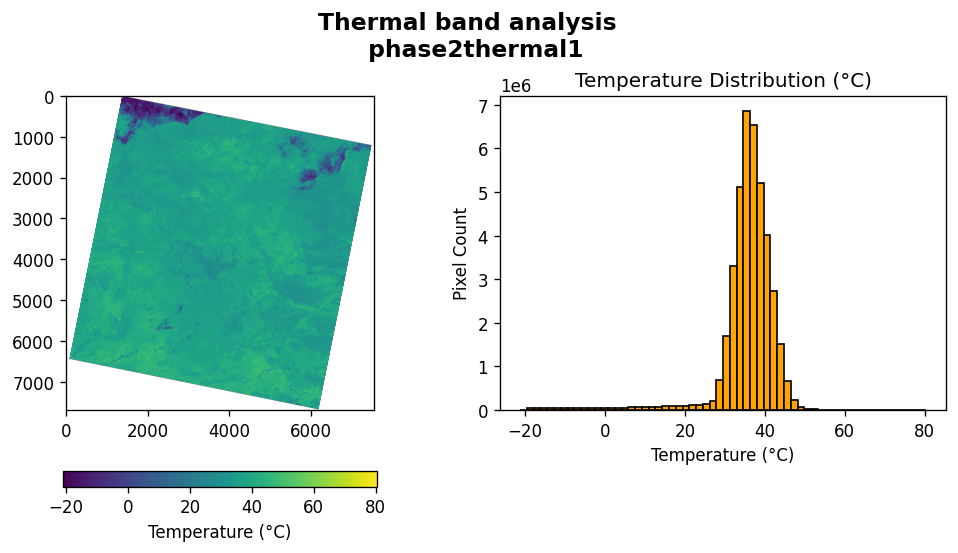

In [41]:
## We are now in a position to plot things side by side.
# First we set up the plot superstructure
# Set up the plot
fig, axes = plt.subplots(
    1,
    2,
    figsize=(4 * 2, 4.5 * 1),
    constrained_layout=True,
    dpi=120,
)

# Then transform the bands to BIP
image_cube_transformer = ImageCubeOperations()
transformed_bands = image_cube_transformer.convert_cube(
    cube = band,
    from_format = CubeRepresentation.BSQ,
    to_format=CubeRepresentation.BIP,
    output_form="numpy"
)

# Then convert everything to celsius
temperature_transformer = Lc09L2spStTransformer()
transformed_bands = temperature_transformer.transform(
    input_data = transformed_bands,
    unit = Temperature.CELSIUS
)

# Having done this we can draw a plot
fig.suptitle(
            f"Thermal band analysis \n phase2thermal1",
            fontsize=14,
            fontweight="bold",
        )
axes_flat = [axes]

# Do an imshow on the first plot with transformed bands
im = axes[0].imshow(
    transformed_bands,  # Show the first channel/band in Celsius
    cmap="viridis"
)
cbar = fig.colorbar(
    im,
    ax=axes[0],
    orientation="horizontal",
    fraction=0.05,
    pad=0.02,
)
cbar.set_label("Temperature (°C)", fontsize=10)

compressed_data = transformed_bands.compressed()

# On the second axes, plot the histogram of the compressed temperature data
axes[1].hist(
    compressed_data,
    bins=60,
    color="orange",
    edgecolor="black"
)
axes[1].set_title("Temperature Distribution (°C)")
axes[1].set_xlabel("Temperature (°C)")
axes[1].set_ylabel("Pixel Count")